In [1]:
# Reproducibility
seed = 125

# Architecture
input_shape = (256, 256, 1)
kernel_shape = (3, 3)
pool_size = (2, 2)

# Training
fake_path = "./data/AI recognition dataset/fakeV2/fake-v2"
path_real = "./data/AI recognition dataset/real"
initial_learning_rate = 0.001
batch_size = 16
sample_frac = 1
epochs = 50
patience = 10
decay_after_n_epochs = 10
decay_rate = 0.5
verbose = 1
l2_regularization = 0.001
params = {
    "epochs": epochs,
    "batch_size": batch_size,
    "patience": patience,
    "seed": seed,
    "verbose": verbose,
    "sample_frac": sample_frac,
    "l2_regularization": l2_regularization
}

model_id = f"model_v{params['epochs']}_bs{params['batch_size']}_pat{params['patience']}_frac_{sample_frac}"
checkpoint_path = f"./checkpoints/{model_id}.keras"

In [2]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import layers, Model, mixed_precision
import keras.backend as K
import keras

import tensorflow as tf
from preprocessing.patch_generator import preprocess
from sklearn.model_selection import train_test_split
from typing import List, Tuple, Union
import matplotlib.pyplot as plt
import numpy as np
import json
import os

2025-05-04 13:57:23.250852: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-04 13:57:23.267867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746377843.289759  824036 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746377843.295714  824036 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746377843.309872  824036 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
mixed_precision.set_global_policy('mixed_float16')

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Available GPUs: {gpus}")

    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPUs available.")

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
print(tf.__version__)

2.19.0


I0000 00:00:1746377846.353705  824036 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


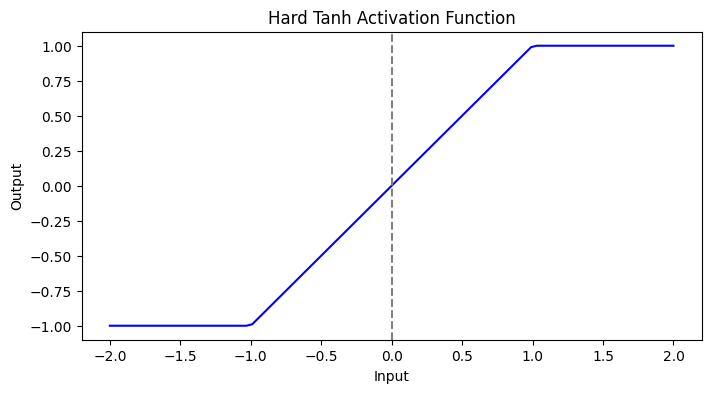

In [6]:
@tf.function
def hard_tanh(x) -> tf.Tensor:
    return tf.maximum(tf.minimum(x, 1), -1)

x_values = np.linspace(-2, 2, 100)
y_values = hard_tanh(tf.convert_to_tensor(x_values)).numpy()

plt.figure(figsize=(8, 4))
plt.plot(x_values, y_values, color="blue")
plt.title("Hard Tanh Activation Function")
plt.xlabel("Input")
plt.ylabel("Output")
plt.axvline(0, color="gray", linestyle="--")
plt.show()

In [7]:
def load_images(
    path: str,
    label: int,
    sample_frac: Union[int, float]) -> Tuple[List[str], List[int]]:
    imgs = [os.path.join(path, img) for img in os.listdir(path)]

    if isinstance(sample_frac, int) and sample_frac > 1:
        sample_count = min(sample_frac, len(imgs))
    else:
        sample_count = int(len(imgs) * sample_frac)

    sampled_imgs = imgs[:sample_count]
    labels = [label for _ in range(len(sampled_imgs))]
    return sampled_imgs, labels

ai_imgs, ai_label = load_images(fake_path, 1, sample_frac)
real_imgs, real_label = load_images(path_real, 0, sample_frac)

In [8]:
X = ai_imgs + real_imgs
y = ai_label + real_label

X_train, X_validate, y_train, y_validate = train_test_split(
    X, y, train_size=0.10, test_size=0.3, random_state=seed, stratify=y
)

def dict_map(X1, X2, y):
    return {"rich_texture": X1, "poor_texture": X2}, y

def set_shapes(frt, fpt, label=None):
    frt.set_shape(input_shape)
    fpt.set_shape(input_shape)
    if label is not None:
        label.set_shape([])
        return frt, fpt, label
    else:
        return frt, fpt

dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(len(X_train), seed)
    .map(
        lambda filepath, label: tf.py_function(
            preprocess, [filepath, label], [tf.float64, tf.float64, tf.int32]
        )
    )
    .map(set_shapes)
    .map(dict_map)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

validation_set = (
    tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
    .map(
        lambda filepath, label: tf.py_function(
            preprocess, [filepath, label], [tf.float64, tf.float64, tf.int32]
        )
    )
    .map(set_shapes)
    .map(dict_map)
    .batch(10)
    .prefetch(tf.data.AUTOTUNE)
)

In [9]:
from collections import Counter
Counter(y_validate)

Counter({1: 5358, 0: 1134})

In [10]:
REG_PARAMS = {"kernel_regularizer": keras.regularizers.l2(l2_regularization)}

class FeatureExtractionLayer(layers.Layer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", **REG_PARAMS)
        self.bn = layers.BatchNormalization()
        self.activation = layers.Lambda(hard_tanh)

    def call(self, input):
        x = self.conv(input)
        x = self.bn(x)
        x = self.activation(x)
        return x

input0 = layers.Input(shape=input_shape, name="rich_texture")
input1 = layers.Input(shape=input_shape, name="poor_texture")

l0 = FeatureExtractionLayer(name="feature_extraction_layer_rich_texture")(input0)
l1 = FeatureExtractionLayer(name="feature_extraction_layer_poor_texture")(input1)

contrast = layers.subtract((l0, l1))

x = layers.Conv2D(filters=32, kernel_size=kernel_shape, activation="relu", **REG_PARAMS)(contrast)
x = layers.BatchNormalization()(x)
for i in range(3):
    x = layers.Conv2D(filters=32, kernel_size=kernel_shape, activation="relu", **REG_PARAMS)(x)
    x = layers.BatchNormalization()(x)
x = layers.BatchNormalization()(x)

for i in range(4):
    x = layers.Conv2D(filters=32, kernel_size=kernel_shape, activation="relu", **REG_PARAMS)(x)
    x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D(pool_size)(x)

for i in range(2):
    x = layers.Conv2D(filters=32, kernel_size=kernel_shape, activation="relu", **REG_PARAMS)(x)
    x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D(pool_size)(x)

for i in range(2):
    x = layers.Conv2D(filters=32, kernel_size=kernel_shape, activation="relu", **REG_PARAMS)(x)
    x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(1, activation="sigmoid", **REG_PARAMS)(x)

model = Model(
    inputs=(input0, input1), outputs=x, name="rt_pt_contrast"
)

steps_per_epoch  = int(len(X_train) / batch_size)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=steps_per_epoch * decay_after_n_epochs,
    decay_rate=decay_rate
)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.Precision()])
model.summary()

Model: "rt_pt_contrast"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rich_texture        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ poor_texture        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 256, 256,  │          0 │ rich_texture[0][… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 256, 256,  │          0 │ poor_texture[0][… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_extraction… │ (None, 254, 254,  │        448 │ cast[0][0]        │
│ (FeatureExtraction… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_extraction… │ (None, 254, 254,  │        448 │ cast_1[0][0]      │
│ (FeatureExtraction… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 254, 254,  │          0 │ feature_extracti… │
│                     │ 32)               │            │ feature_extracti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 252, 252,  │      9,248 │ subtract[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 252, 252,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 250, 250,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 250, 250,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 248, 248,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 248, 248,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 246, 246,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 246, 246,  │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 246, 246,  │        128 │ batch_normalizat… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 244, 244,  │      9,248 │ batch_normalizat

 Total params: 113,569 (443.63 KB)

 Trainable params: 112,609 (439.88 KB)

 Non-trainable params: 960 (3.75 KB)

## Making data pipeline

In [11]:
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path, monitor="val_loss", save_best_only=True, verbose=verbose
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss", patience=patience, verbose=verbose, restore_best_weights=True
)

## Training the model

In [13]:
history = model.fit(
    dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    batch_size=batch_size,
    validation_data=validation_set,
    callbacks=[checkpoint_callback, early_stopping_callback],
)

Epoch 1/50


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.8837 - loss: 0.6911 - precision: 0.9094 - recall: 0.9532

2025-05-04 14:47:46.275725: W tensorflow/core/framework/op_kernel.cc:1844] UNKNOWN: DecompressionBombError: Image size (232748750 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
Traceback (most recent call last):

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/.venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/.venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 145, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/.venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 152, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "/home/llbs/www/cin/deep-learning/ai-generation-detectio

UnknownError: Graph execution error:

Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  Error in user-defined function passed to MapDataset:8 transformation with iterator: Iterator::Root::Prefetch::MapAndBatch::Map: DecompressionBombError: Image size (232748750 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
Traceback (most recent call last):

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/.venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/.venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 145, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/.venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 152, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/.venv/lib/python3.12/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/preprocessing/patch_generator.py", line 296, in preprocess
    rt, pt = smash_n_reconstruct(path)
             ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/preprocessing/patch_generator.py", line 275, in smash_n_reconstruct
    return generator.process_image(input_path, use_filters, is_color)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/preprocessing/patch_generator.py", line 226, in process_image
    img = self.load_image(input_path)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/preprocessing/patch_generator.py", line 51, in load_image
    img = PIL.Image.open(fp=input_path)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/.venv/lib/python3.12/site-packages/PIL/Image.py", line 3288, in open
    im = _open_core(fp, filename, prefix, formats)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/.venv/lib/python3.12/site-packages/PIL/Image.py", line 3275, in _open_core
    _decompression_bomb_check(im.size)

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/.venv/lib/python3.12/site-packages/PIL/Image.py", line 3183, in _decompression_bomb_check
    raise DecompressionBombError(msg)

PIL.Image.DecompressionBombError: Image size (232748750 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_6]]
  (1) UNKNOWN:  Error in user-defined function passed to MapDataset:8 transformation with iterator: Iterator::Root::Prefetch::MapAndBatch::Map: DecompressionBombError: Image size (232748750 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
Traceback (most recent call last):

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/.venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/.venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 145, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/.venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 152, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/.venv/lib/python3.12/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/preprocessing/patch_generator.py", line 296, in preprocess
    rt, pt = smash_n_reconstruct(path)
             ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/preprocessing/patch_generator.py", line 275, in smash_n_reconstruct
    return generator.process_image(input_path, use_filters, is_color)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/preprocessing/patch_generator.py", line 226, in process_image
    img = self.load_image(input_path)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/preprocessing/patch_generator.py", line 51, in load_image
    img = PIL.Image.open(fp=input_path)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/.venv/lib/python3.12/site-packages/PIL/Image.py", line 3288, in open
    im = _open_core(fp, filename, prefix, formats)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/.venv/lib/python3.12/site-packages/PIL/Image.py", line 3275, in _open_core
    _decompression_bomb_check(im.size)

  File "/home/llbs/www/cin/deep-learning/ai-generation-detection/.venv/lib/python3.12/site-packages/PIL/Image.py", line 3183, in _decompression_bomb_check
    raise DecompressionBombError(msg)

PIL.Image.DecompressionBombError: Image size (232748750 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_46961]

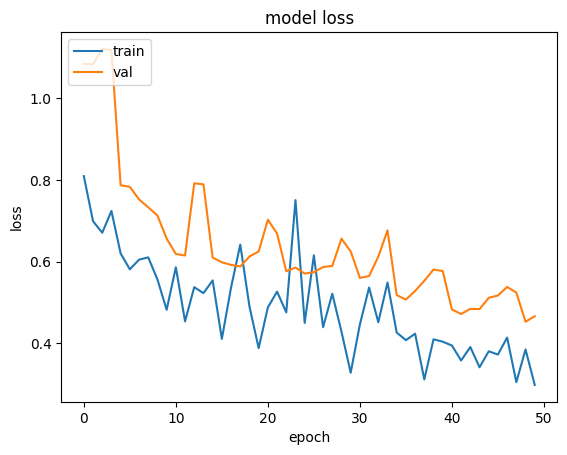

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [ ]:
history.history

{'binary_accuracy': [0.8154761791229248,
  0.9285714030265808,
  0.9092261791229248,
  0.8571428656578064,
  0.9241071343421936,
  0.8928571343421936,
  0.9166666865348816,
  0.9285714030265808,
  0.9360119104385376,
  0.9642857313156128,
  0.925595223903656,
  0.9642857313156128,
  0.9434523582458496,
  0.9285714030265808,
  0.925595223903656,
  0.9642857313156128,
  0.9270833134651184,
  0.9285714030265808,
  0.9523809552192688,
  1.0,
  0.9523809552192688,
  0.9285714030265808,
  0.9523809552192688,
  0.8928571343421936,
  0.9583333134651184,
  0.8214285969734192,
  0.9538690447807312,
  0.9285714030265808,
  0.9642857313156128,
  1.0,
  0.949404776096344,
  0.9285714030265808,
  0.9523809552192688,
  0.9285714030265808,
  0.961309552192688,
  0.9285714030265808,
  0.949404776096344,
  1.0,
  0.9717261791229248,
  0.9642857313156128,
  0.96875,
  0.9642857313156128,
  0.96875,
  1.0,
  0.9672619104385376,
  0.9642857313156128,
  0.9553571343421936,
  1.0,
  0.9717261791229248,
  1.0

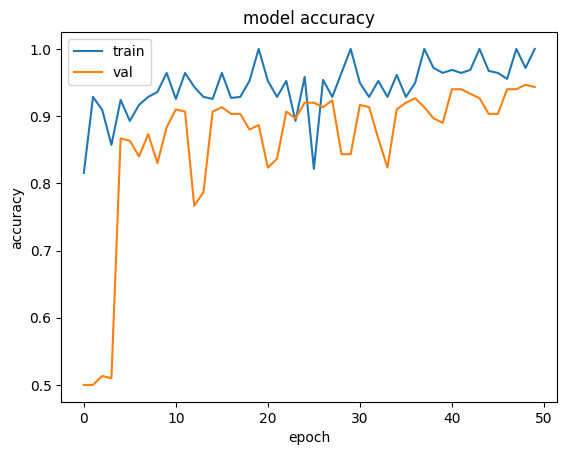

In [ ]:
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [ ]:
def save_model(model_id: str, model: Model, params: dict):
    model_path = f"./models/{model_id}.keras"
    model.save(model_path)
    params["history"] = history.history
    with open(f"./models/{model_id}.json", "w") as f:
        json.dump(params, f, indent=4)
    
    return model_path

In [ ]:
model_path = save_model(model_id, model, params)

In [ ]:
from tensorflow.keras import models

def inference(model_path, images_path):
    custom_objects = {
        'FeatureExtractionLayer': FeatureExtractionLayer,
        'hard_tanh': hard_tanh
    }
    model = models.load_model(model_path, custom_objects=custom_objects)

    image_paths = [os.path.join(images_path, fname) for fname in os.listdir(images_path)][:5]
    dummy_labels = [0] * len(image_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, dummy_labels))

    dataset = dataset.map(
        lambda path, label: tf.py_function(
            preprocess, [path, label], [tf.float64, tf.float64, tf.int32]
        )
    )

    dataset = dataset.map(set_shapes)
    dataset = dataset.map(lambda frt, fpt, label: {'rich_texture': frt, 'poor_texture': fpt})
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    predictions = model.predict(dataset, batch_size=batch_size)

    return predictions

In [ ]:
preds = inference(model_path, "./data/AI recognition dataset/fakeV2/fake-v2")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
preds

array([[0.9501062 ],
       [0.90735847],
       [0.9809298 ],
       [0.9759759 ],
       [0.9870185 ]], dtype=float32)

In [ ]:
preds_real = inference(model_path, "./data/AI recognition dataset/real")
preds_real

c:\Users\yveem\anaconda3\envs\detection\Lib\site-packages\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'feature_extraction_layer_rich_texture', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\yveem\anaconda3\envs\detection\Lib\site-packages\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'feature_extraction_layer_poor_texture', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[0.00274754],
       [0.72200346],
       [0.8098036 ],
       [0.85625684],
       [0.9681962 ]], dtype=float32)